# Bayesian Statistics for Physicists

<em>Note: This notebook was presented at the EMMI workshop <a href="https://indico.gsi.de/event/7534/">"Uncertainty Quantification (UQ) at the Extremes (ISNET-6)"</a> on 9-October-2018.  
    It has been replaced for further development by the multipart BSFP_pn_xxx.ipynb notebooks.</em>

## <a name="Overview">Overview</a>

A brief, hands-on introduction to the basics of Bayesian statistics in a manner adapted to the general intuition and experience of physicists.  We use a Jupyter notebook with Python (scipy, numpy, mathplotlib) to allow for active visualization of examples, hands-on follow-ups, and readily extended content. You can find the notebook and associated files at
https://github.com/furnstahl/Bayes_for_physicists.

This is not an exhaustive guide to Bayesian statistics, but a selected sampling of topics that come up regularly in physics applications, with links to more information.
Most of the examples were adapted from code found on the web.
Please contribute suggestions, comments, links, code, ...

Last revised: 13-Oct-2018 by Dick Furnstahl [furnstahl.1@osu.edu].

<hr>

## <a name="Contents">Contents</a> 

<ul>
    <li><a href="#Overview">Overview</a>
    <li><a href="#Python">Python set up</a>
    <li><a href="#Basics">Bayesian basics</a> 
        [<a href="#Rules">Rules</a>]
        [<a href="#Networks">Networks</a>]
        [<a href="#Discrepancy">Model discrepancy</a>] 
    <li><a href="#Priors">Choosing priors</a>
        [<a href="#MaxEntropy">Maximum entropy</a>]
        [<a href="#ConjPriors">Conjugate priors</a>]
    <li><a href="#Updating">Bayesian updating examples</a>  
    <li><a href="#Sampling">Sampling</a>
        [<a href="#Multivariate">Multivariate gaussian</a>]
        [<a href="#MCMC">MCMC</a>]
    <li><a href="#Evidence">Model selection: Bayes ratio and evidence</a>
    <li><a href="#GPs">Gaussian processes</a> 
    <li><a href="#Appendices">Appendices</a>: 
         [<a href="#References">References</a>]
         [<a href="#Vocabulary">Vocabulary</a>]
         [<a href="#Notation">Notation</a>] 
</ul>

<hr>

## <a name="Python">Python/Jupyter set up</a>

We recommend installing the standard Anaconda Python3 package (from https://www.anaconda.com/download), which is available for Windows, Mac OS X, and Linux.  Anaconda will provide scipy, numpy, matplotlib, and jupyter notebooks (and more!).  

<span class="blue">You can start this notebook from the <a href="https://docs.anaconda.com/anaconda/navigator/">Anaconda Navigator</a> or from the command line (go to the directory with this notebook and type: <code>jupyter notebook</code>).</span>

It is convenient to use the Jupyter notebook extensions "Code Folding" and "Collapsible Headings", which can be turned on using the jupyter_nbextensions_configurator extension after installing via <br>
<code>conda install -c conda-forge jupyter_contrib_nbextensions</code> 
<br> (see https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/ for a complete list and full instructions). 

Other packages you will need to install for this notebook:
<ul>
    <li>pymc3 [conda install -c conda-forge pymc3]
    <li>emcee [conda install -c astropy emcee]
    <li>corner [conda install -c astropy corner]
</ul>

In [2]:
# set up for plots in this notebook using matplotlib (there are other plotting choices)
%matplotlib inline   

In [3]:
import numpy as np

import scipy.stats as stats
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt
#plt.style.use('seaborn') # pretty matplotlib plots

import corner
import pymc3 as pm


/Users/furnstah/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# make font adjustments
#plt.rcParams['font.size'] = 12
#plt.rcParams['legend.fontsize'] = 'medium'
#plt.rcParams['figure.titlesize'] = 'medium'
plt.rcdefaults()  # revert to defaults for now

In [5]:
%%html  
<!-- Use html cell magic to add css styling -->
<style>
  em {
      color: red;
  }
  dd {
      margin-left: 15px;
  }
  .red{color: red}
  .blue{color: blue}
</style>

In [6]:
#%%javascript
#IPython.OutputArea.auto_scroll_threshold = 9999;

## <a name="Basics">Bayesian basics</a>

### Why should physicists use Bayesian statistics?

cf. <a href="https://www.astro.princeton.edu/~strauss/AST303/bayesian_paper.pdf">Why isn't every physicist a Bayesian?</a> from 1995.

<ul>
   <li>Includes conventional physics statistics (e.g., for parameter estimation)
   <li>Calculate what you really want, e.g., probability for some parameter vs. frequentist confidence interval    
   <li>Assumptions are made explicit (in the form of priors)
   <li>Allows us to account for "nuisance parameters"    
   <li>Well suited for theory errors, which are generally systematic
   <li>Clear prescription for combining different types of errors 
   <li>Model selection: compare different theoretical models (or combine!)
   <li>Model checking: we can test if our UQ model works and study sensitivities
    <li><em>Statistics as diagnostic and discovery tools for physics</em>
    <li> **[add your own favorite reasons]**
</ul>

### Everything is a pdf (probability density function)

Physicists are used to multidimensional normalized pdfs as wave functions squared, e.g. probability density for particle 1 at $x_1$ and particle 2 at $x_2$:

<span class="red">
 $$
 |\Psi(x_1, x_2)|^2 \Longrightarrow p(x_1,x_2) \equiv p(\textbf{x})  
   \quad \mbox{with}\quad \textbf{x} 
 \equiv \{x_1,x_2\}
 $$
</span> 

(Other notation for generic pdfs: $p(\textbf{x}) = P(\textbf{x}) = \textrm{pr}(\textbf{x}) = \textrm{prob}(\textbf{x}) = \ldots$ )

$p(x_1,x_2)$ is the <em>joint probability density</em> of $x_1$ and $x_2$. <br>
What is the probability to find particle 1 at $x_1$ and particle 2 anywhere?  $\int\! |\Psi(x_1,x_2)|^2 dx_2$ <br>
The <em>marginal probability density</em> of $x_1$ is: 
$\color{blue}{p(x_1) = \int\! p(x_1,x_2)\,dx_2}$. <br>
"Marginalizing" = "integrating out" (eliminates "nuisance parameters" from posterior).  

Just as with "Lagrangian", we will not always be careful about saying probability vs. probability density.

In Bayesian statistics there are pdfs (or pmfs if discrete) for data, experimental <i>and</i> theoretical uncertainties, fit parameters, hyperparameters (what?), events (Will it rain tomorrow?), etc.  Even if definite $x_0$, we can use $p(x) = \delta(x-x_0)$.  


### Visualization of pdfs

#### Matplotlib plotting definitions

In [7]:
def dist_stuff(dist):
    """
    Find the median, mean, and 68%/95% credible intervals 
     for the given 1-d distribution (from stats).
    """
    median = [dist.median(), dist.pdf(dist.median())]
    mean = [dist.mean(), dist.pdf(dist.mean())]
    cred68 = dist.interval(0.68)
    cred95 = dist.interval(0.95)
    return median, mean, cred68, cred95

def dist_mode(dist, x):
    """
    Find the mode (maximum) of the 1-d distribution.
    """
    x_max_index = dist.pdf(x).argmax()
    mode = [x[x_max_index], dist.pdf(x[x_max_index])]
    return mode

def dist_plot(dist_label, x_dist, dist, plot_num):
    """
    Plot the distribution, indicating median, mean, mode
    and 68%/95% probability intervals.
    """
    colors = ('blue', 'blue', 'blue')
    median, mean, cred68, cred95 = dist_stuff(dist)
    mode = dist_mode(dist, x_dist)
    
    plt.subplot(1,3,plot_num)
    plt.plot(x_dist,dist.pdf(x_dist), label=dist_label, color=colors[plot_num-1])
    text_x = 0.2*(x_dist[-1]-x_dist[0])
    text_x_mid = (x_dist[-1]+x_dist[0])/2
    text_y = mode[1]*1.15
    plt.annotate('median', xy=median, xytext=(text_x_mid+text_x, text_y),
            arrowprops=dict(facecolor='black', shrink=0.05))
    plt.annotate('mode', xy=mode, xytext=(text_x_mid-text_x, text_y),
            arrowprops=dict(facecolor='red', shrink=0.05))
    plt.annotate('mean', xy=mean, xytext=(text_x_mid, text_y),
            arrowprops=dict(facecolor='blue', shrink=0.05))
    plt.xlabel('x')
    plt.ylabel('p(x)')
    plt.fill_between(x_dist, 0, dist.pdf(x_dist), 
                 where=((x_dist > cred68[0]) & (x_dist < cred68[1])), 
                 facecolor='blue', alpha=0.2)
    plt.fill_between(x_dist, 0, dist.pdf(x_dist), 
                 where=((x_dist > cred95[0]) & (x_dist < cred95[1])), 
                 facecolor='blue', alpha=0.1)
    plt.legend();



#### Some standard pdfs: normal and beta distributions

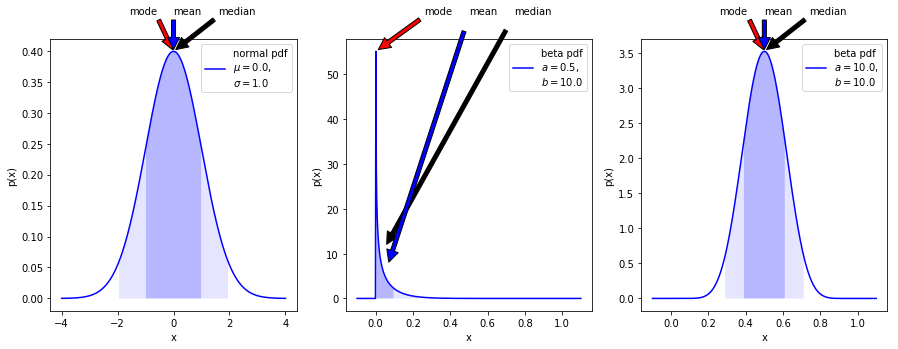

In [8]:
%matplotlib inline

# Make some standard plots
plt.figure(figsize=(15,5))

# Standard normal distribution
x_norm = np.linspace(-4, 4, 500)
mu = 0     # mean
sigma = 1.0  # standard deviation
norm_dist = stats.norm(mu, sigma) # the normal distribution
norm_label='normal pdf' + '\n' + r'$\mu=${:1.1f},'.format(mu) \
             + '\n' + r'$\sigma=${:1.1f}'.format(sigma) 
dist_plot(norm_label, x_norm, norm_dist, 1)

# beta distribution
x_beta = np.linspace(-0.1, 1.1, 500)
a1 = .5
b1 = 10
beta_dist = stats.beta(a1, b1)
beta1_label='beta pdf' + '\n' + r'$a=${:1.1f}'.format(a1) \
              + ',\n$b=${:1.1f}'.format(b1) 
dist_plot(beta1_label, x_beta, beta_dist, 2)

# another beta distribution
#x_beta = np.linspace(-0.1, 1.1, 500)
a2 = 10
b2 = 10
beta2_dist = stats.beta(a2, b2)
beta2_label='beta pdf' + '\n' + r'$a=${:1.1f}'.format(a2) \
              + ',\n$b=${:1.1f}'.format(b2) 
dist_plot(beta2_label, x_beta, beta2_dist, 3)


The 68%/95% probability regions are shown in dark/light shading.  When applied to posteriors, these are known as <em>credible intervals</em> or DoBs (degree of belief intervals) or Bayesian confidence intervals. The horizontal extent on the $x$-axis translates into the vertical extent of the error bar or error band for $x$.


#### More standard pdfs:  Student t

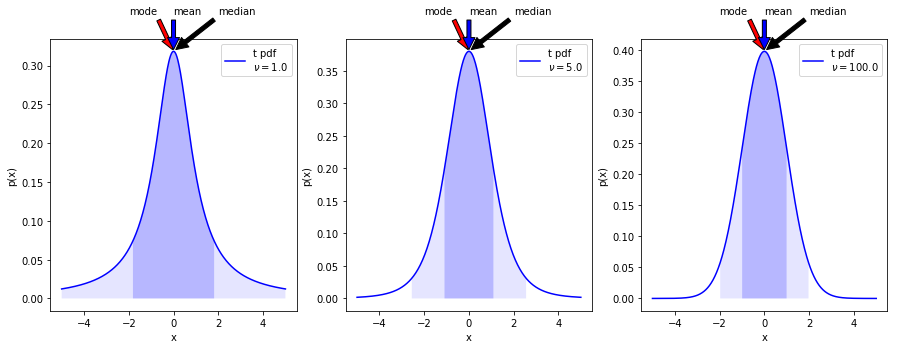

In [9]:
%matplotlib inline

# Make some plots of the Student t distribution
plt.figure(figsize=(15,5))

x_t = np.linspace(-5, 5, 500)

nu1 = 1
t1_dist = stats.t(nu1) # the Student t distribution
t1_label='t pdf' + '\n' + r'$\nu=${:1.1f}'.format(nu1) 
dist_plot(t1_label, x_t, t1_dist, 1)

nu2 = 5
t2_dist = stats.t(nu2) # the Student t distribution
t2_label='t pdf' + '\n' + r'$\nu=${:1.1f}'.format(nu2) 
dist_plot(t2_label, x_t, t2_dist, 2)

nu3 = 100
t3_dist = stats.t(nu3) # the Student t distribution
t3_label='t pdf' + '\n' + r'$\nu=${:1.1f}'.format(nu3) 
dist_plot(t3_label, x_t, t3_dist, 3)


Note the "heavy tails" in the t distribution as $\nu$ gets small.  As $\nu$ gets large, the distribution approaches a standard normal (Gaussian) distribution.

#### Projected posterior plots

Here we use the [corner package](https://corner.readthedocs.io/en/latest/api.html) to make some projected posterior plots.

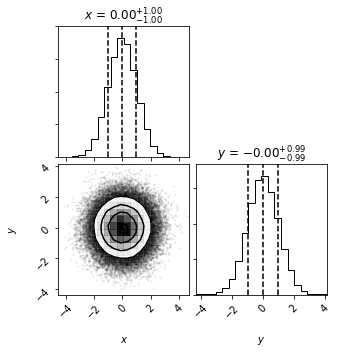

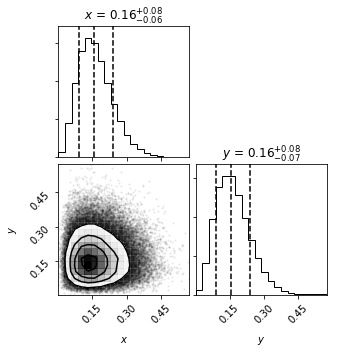

In [10]:
%matplotlib inline
# examples of corner plots
ndim, nsamples = 2, 100000
#np.random.seed(42)
# generate some fake data from a normal distribution
norm_samples = stats.norm.rvs(size=ndim * nsamples).reshape([nsamples, ndim])
#figure = corner.corner(norm_samples)
figure1 = corner.corner(norm_samples, labels=[r"$x$", r"$y$", r"$\log \alpha$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
ax = figure1.get_axes()
figure1.set_size_inches(5,5)

ndim, nsamples = 2, 100000
#np.random.seed(42)
# generate some fake data from a beta distribution
a = 4
b = 20
beta_samples = stats.beta(a,b).rvs(size=ndim * nsamples).reshape([nsamples, ndim])
#figure = corner.corner(beta_samples)
figure2 = corner.corner(beta_samples, labels=[r"$x$", r"$y$", r"$\log \alpha$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
figure2.set_size_inches(5,5)


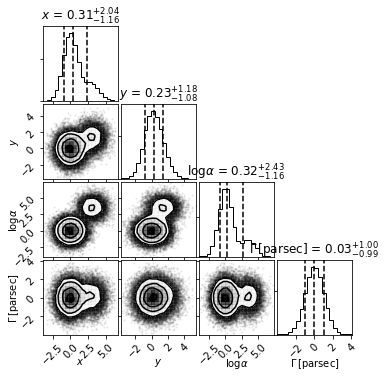

In [11]:
%matplotlib inline
# now more than one mode (all random)
ndim, nsamples = 4, 50000
np.random.seed(1234)
data1 = np.random.randn(ndim * 4 * nsamples // 5).reshape([4 * nsamples // 5, ndim])
mean = 4*np.random.rand(ndim)
data2 = (mean[None, :] + np.random.randn(ndim * nsamples // 5).reshape([nsamples // 5, ndim]))
samples = np.vstack([data1, data2])

#figure = corner.corner(samples)
figure = corner.corner(samples, labels=[r"$x$", r"$y$", r"$\log \alpha$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

figure.set_size_inches(5,5)


### Sampling of 1d pdfs in Python

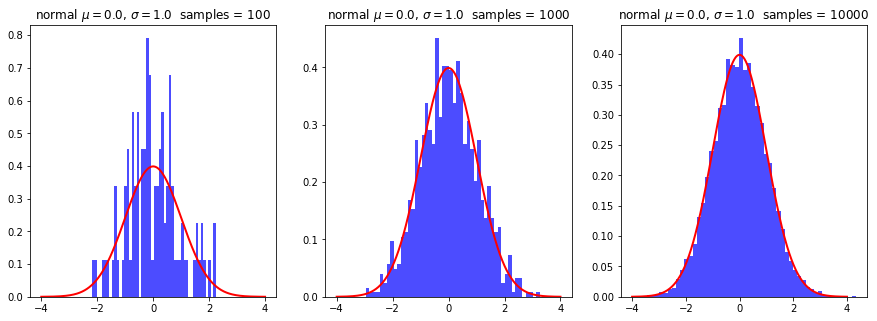

In [12]:
%matplotlib inline

def plot_hist(name, x_dist, dist, num_samples, num_bins, plot_num):
    plt.subplot(1,3,plot_num)
    samples = dist.rvs(size=num_samples)
    count, bins, ignored = plt.hist(samples, num_bins, density=True,
                                     color='blue', alpha=0.7)
    plt.plot(x_dist,dist.pdf(x_dist), linewidth=2, color='r')
    title_string = name + '  samples = {:d}'.format(num_samples)
    plt.title(title_string)
    

mu, sigma = 0, 1.0 # mean and standard deviation
x_dist = np.linspace(-4, 4, 500)
name = r'normal $\mu=${:1.1f}, $\sigma=${:1.1f}'.format(mu,sigma)
plt.figure(figsize=(15,5))
num_bins = 50

num_samples = 100
norm_dist = stats.norm(mu, sigma)
plot_hist(name, x_dist, norm_dist, num_samples, num_bins, 1)

num_samples = 1000
norm_dist = stats.norm(mu, sigma)
plot_hist(name, x_dist, norm_dist, num_samples, num_bins, 2)

num_samples = 10000
norm_dist = stats.norm(mu, sigma)
plot_hist(name, x_dist, norm_dist, num_samples, num_bins, 3)


<hr>

### Bayes' Rule: Interaction of prior and likelihood

$A$ and $B$ are generic propositions and $I$ is "information" (things we know).  $p(A \mid B)$ means the probability of $A$ given $B$ (or <em>contingent</em> or <em>conditional</em> on $B$). 

A particular case is a vector of parameters $\textbf{a} = \{a_1, a_2, \cdots\}$ for a theoretical model and some data it describes. Here Bayes' Rule is being used for <em>parameter estimation</em>.

$$
  \newcommand{\avec}{\textbf{a}}
  p(A \mid B,I) = 
        \frac{p(B \mid A,I)\, p(A \mid I)}{p(B \mid I)}
  \ \Longrightarrow\ 
   \overbrace{p(\avec \mid \textrm{data},I)}^{\textrm{posterior}} =
  \frac{\color{red}{\overbrace{p(\textrm{data} \mid \avec,I)}^{\textrm{likelihood}}} \times
   \color{blue}{\overbrace{p(\avec \mid I)}^{\textrm{prior}}}}
   {\color{darkgreen}{\underbrace{p(\textrm{data} \mid I)}_{\textrm{evidence}}}}
$$

Common notation in statistics: $\boldsymbol{\theta}$ for parameters, $\mathcal{L}$ or $L$ for the likelihood, $\pi(\boldsymbol{\theta})$ for the prior. 

<hr>

$$\overbrace{p(\avec \mid \textrm{data},I)}^{\textrm{posterior}} \propto \color{red}{\overbrace{p(\textrm{data} \mid \avec,I)}^{\textrm{likelihood}}} \times
   \color{blue}{\overbrace{p(\avec \mid I)}^{\textrm{prior}}}$$

Left: likelihood overwhelms prior.  Right: prior is returned (restricts domain)

<div style="float:left"><img src="figures/Ann_Phys_D1_Cp_abar0_5_k_3_a_1.png" width="250" ></div>
<div style="float:left"><img src="figures/Ann_Phys_D1_Cp_abar0_5_k_3_a_3.png" width="250"></div>
<div style="clear: both"></div>

Note: these are one-dimensional projections of multi-dimensional pdfs.  <br>
<em>Here we don't need to calculate the evidence separately; just normalize the numerator.</em>

<hr>

### Bayesian rules of probability as principles of logic 

Notation: $p(x \mid I)$ is the probability (or pdf) of $x$ being true
given information $I$

<ol>
    <li> <b>Sum rule:</b> If set $\{x_i\}$ is exhaustive and exclusive, 
  $$ \sum_i p(x_i  \mid  I) = 1   \quad \longrightarrow \quad       \color{red}{\int\!dx\, p(x \mid I) = 1} 
  $$ </li>
 <ul>
    <li> cf. complete and orthonormal </li>
    <li> implies <em>marginalization</em> (cf. inserting complete set of states or integrating out variables)
  $$
   p(x \mid  I) = \sum_j p(x,y_j \mid I) 
    \quad \longrightarrow \quad
   \color{red}{p(x \mid I) = \int\!dy\, p(x,y \mid I)} 
  $$
    </li>
  </ul>
  
    <li> <b>Product rule:</b> expanding a joint probability of $x$ and $y$         
        $$
         \color{red}{ p(x,y \mid I) = p(x \mid y,I)\,p(y \mid I)
              = p(y \mid x,I)\,p(x \mid I)}
        $$
    </li>    
  <ul>
    <li> If $x$ and $y$ are <em>mutually independent</em>:  $p(x \mid y,I)
      = p(x \mid I)$, then        
    $$
       p(x,y \mid I) \longrightarrow p(x \mid I)\,p(y \mid I)
    $$
    </li>    
    <li> Rearranging the second equality yields <em> Bayes' Rule (or Theorem)</em>
     $$
      \color{blue}{p(x  \mid y,I) = \frac{p(y \mid x,I)\, 
       p(x \mid I)}{p(y \mid I)}}
     $$
    </li>
  </ul>
</ol>

See <a href="https://www.amazon.com/Algebra-Probable-Inference-Richard-Cox/dp/080186982X/ref=sr_1_1?s=books&ie=UTF8&qid=1538835666&sr=1-1">Cox</a> for the proof.

### Bayesian model checking: one example

<span class="red">How can you evaluate whether your Bayesian predictions are working?</span>  
Cf. checking whether a least-squares fit to data with  Gaussian noise misses about 1/3 of your 1-$\sigma$ error bars.
More generally: are the residuals normally distributed?

<em>Are your Bayesian credible intervals consistent with observed successes?</em> Check with a <em>calibration</em> or <em>empirical coverage</em> or <em>credible interval diagnostic</em> plot.

<div style="float:left"><img src="figures/VelocityVsTimeFit.png" width="250" ></div>
<div style="float:left"><img src="figures/weather-forecast-accuracy-flipped.png" width="250"></div>
<div style="clear: both"></div>



<span class="blue">To be discussed: other ways to do Bayesian model checking.</span>

### <a name="Netwoks">Networks</a>

A Bayesian network is a graphical model that makes conditional dependence explicit through the edges in a directed graph.  <span class="red">(More on this soon!)</span> 

<div style="float:left"><img src="figures/Bayesian_Network_2.png" width="220"></div>
<div style="float:right"><img src="figures/Bayesian_Network_independent_lecs_2_v4.png" width="350" ></div>
<div style="clear: both"></div>


### <a name="Discrepancy">Model discrepancy</a>

$\newcommand{\yexp}{\textbf{y}_{\rm exp}}$
$\newcommand{\yth}{\textbf{y}_{\rm th}}$
$\newcommand{\ytrue}{\textbf{y}_{\rm true}}$
The main goal of Bayesian parameter estimation is the calculation of a joint posterior pdf for the model parameters given a set of experimental data and any other information we have.  This task begins with a <em>statistical model</em>:
$$ \yexp = \yth + \Delta \yth + \Delta \yexp $$
where $\yexp$ are the experimental measurements of an observable $y$
and $\yth$ are the corresponding theoretical (model) calculations.
In terms of the true results $\ytrue$, we can decompose this as
$$ \yexp = \ytrue + \Delta\yexp\;; \qquad 
   \ytrue = \yth + \Delta\yth  \;.
$$  
The model for the experimental uncertainty $\Delta\yexp$ is usually stochastic noise
$$ \Delta\yexp \sim \mathcal{N}(0,\Sigma_{\rm exp}) $$
with zero mean and $\Sigma_{\rm exp}$ typically uncorrelated (so the covariance matrix is diagonal).  Systematic uncertainties can also be incorporated.  

The "new" feature here is $\Delta\yth$, which is the model discrepancy or model defect.  Its role is to account statistically for the deficiencies of the model.  It could be a truncation error from an expansion or a model of the observed residuals in a set of training data.
By including $\Delta\yth$, we can suppress overfitting and deal with underfitting. 

<p>[Return to <a href="#Contents">Contents</a>]</p>

<hr>

## <a name="Priors">Choosing priors</a>

A key feature of Bayesian statistics is the choice of the prior probability distribution.  We should incorporate all of the information we have, but no more. What are the options for choosing priors?  What are the subtleties?  Places to use an <em>informative prior:</em>

<ul>
  <li>your dataset is small, but there is related information available from other systems;
  <li>your model is very flexible but you want to prevent overfitting (so use priors that prefer
      values close to zero);
  <li>you want to stay away from particular regions of parameter space: maybe strictly unphysical such as
      negative cross sections or acausal, or maybe
      counter to well-motivated assumptions such as parameters are of order unity;
  <li>the posterior from a previous experiment can become a prior ==> Bayesian updating;
  <li>other examples??
</ul>

### <a name="Uniform">Subtlety with uniform prior</a>

An example from the 2016 workshop on [Bayesian Methods in Astronomy](https://github.com/jakevdp/BayesianAstronomy/blob/master/Index.ipynb) considers fitting a straight line $y = mx+b$ to noisy data. If you take the prior on the slope $m$ to be uniform (flat), thinking that this is non-informative, then look at this plot, which samples lines with uniformly distributed slopes:

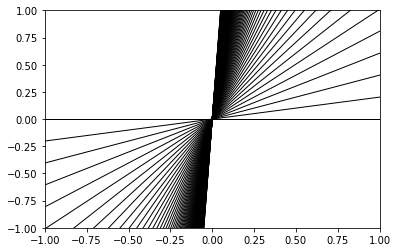

In [13]:
%matplotlib inline
xx = np.linspace(-1, 1,11)
for slope in np.linspace(0, 20, 100):
    plt.plot(xx, slope * xx, '-k', linewidth=1)
plt.axis([-1, 1, -1, 1], aspect='equal');

In [14]:
xx

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

The density of the lines indicates the relative probability of different slopes. Summary point: flat priors are not necessarily minimally informative.  For the slope we probably want a prior that does not artificially over-weight large slopes; see http://arxiv.org/abs/1411.5018 for some discussion. For example, we might use a flat prior on the *angle* the line makes with the x-axis, which implies
$$
P(m) \propto (1 + m^2)^{-3/2}
$$

### <a name="MaxEnt">Maximum entropy for priors (appealing to physicists!)</a>

<ul>
 <li> Basic idea: identify least informative $p(x)$ from maximizing entropy:
   $$
     S[p(x)] = -\int\!dx\, p(x)\, \log\left[\frac{p(x)}{m(x)}\right]
   $$
   subject to constraints from the prior information.
   <ul>
      <li> $m(x)$ is an appropriate measure (often uniform, but see Sivia)
      <li> Use Lagrange multiplier(s) to maximize
   </ul>

 <li> One constraint is always normalization: $\int\!dx\, p(x) = 1$
     $\Longrightarrow$ alone it leads to uniform $p(x)$ (actually to $m(x)$)

 <li>
   If the mean $\mu$ and variance $\sigma^2$ are known, then maximize (may be clearer to do with discretized variables)
  
   \begin{align}
    Q[p(x)] &= -\int\! dx\, p(x)\, \log\left[\frac{p(x)}{m(x)}\right] 
    + \lambda_0 \left[ 1 - \int\! dx\, p(x) \right] \\
     & \quad + \lambda_1 \left[\sigma^2 -  \int\! dx\, (x-\mu)^2 p(x)  \right]
   \end{align}
   
   Then
   $$    
    \frac{\delta Q}{\delta p(x)} = 0   \quad\mbox{and}\quad
     m(x) = \mbox{const.}
     \ \Longrightarrow\ 
     p(x \mid \mu,\sigma) = \frac{1}{\sigma\sqrt{2 \pi}} 
     e^{-(x-\mu)^2/2\sigma^2}    
   $$
   
  <li>
    For $\textbf{x} = \{x_1, \cdots, x_N\}$, we find $p(\textbf{x})$
    is the familiar least-squares likelihood function.  See Sivia for many more details.




If you want a "scale invariant" prior, this often means a flat prior on the *logarithm* of the parameter.  This is an example of a [Jeffreys Prior](https://en.wikipedia.org/wiki/Jeffreys_prior).


<p>[Return to <a href="#Contents">Contents</a>]</p>

<hr>

### <a name="ConjPriors">Conjugate priors</a>

Bayes theorem tells us that the posterior follows from multiplying the prior by the likelihood and normalizing:  

$$ 
  p(\theta\,|\,x) = \frac{p(x\,|\,\theta)\, p(\theta)}
                          {\int\!d\theta'\, p(x\,|\,\theta')\, p(\theta')}
$$ 

If the resulting $p(\theta\,|\,x)$ is in the same family of pdfs as $p(\theta)$, then $p(\theta)$ is said to be a conjugate prior for the likelihood $p(x\,|\,\theta)$. 

The likelihood is often a fixed form. <em>If there is freedom to choose a conjugate prior, the Bayesian updating of the posterior is given in closed form.</em>  

Comments:
 <ul>
    <li>Suppose we are flipping a coin and seek the posterior for the probability of heads $\theta \in [0,1]$.  Let $x$ be the number of successes (heads) in $N$ trials. The likelihood is binomial: 
   $$ p(x\mid\theta) = \binom{N}{x} 
       \theta^{x} (1-\theta)^{N-x} \;. 
   $$
If we choose the prior to be a <i>beta distribution</i> with <em>hyperparameters</em> $a$ and $b$ (which are parameters of the prior as opposed to the model),  
   $$ p(\theta\mid a,b) = \textrm{Beta}(\theta\mid a,b)
      = \frac{\theta^{a-1}(1-\theta)^{b-1}}{B(a,b)}
   $$
with beta function $B(a,b)$, then the posterior is of the same form ($\bar x \equiv N - x$):
   $$ p(\theta\mid x,a,b) = \frac{\theta^{x+a-1}(1-\theta)^{\bar x+b-1}}{B(x+a,\bar x+b)} = \textrm{Beta}(\theta\mid x+a,\bar x +b)
   $$                                 
This posterior can be used as the prior for more samples; the hyperparameters just add additional information (check that it doesn't matter if you analyze the data all at once or sequentially because the tosses are independent).
  <li>See the [Wikipedia article](https://en.wikipedia.org/wiki/Conjugate_prior) for a big table of conjugate prior pairs.
  <li>If the likelihood is a normal distribution with known variance, the conjugate prior is also normal.  If it is a normal distribution with known mean, the inverse gamma distribution is a conjugate prior.
 </ul>

<p>[Return to <a href="#Contents">Contents</a>]</p>

<hr>

## <a name="Updating">Bayesian updating examples</a>

### Determining the bias of a coin

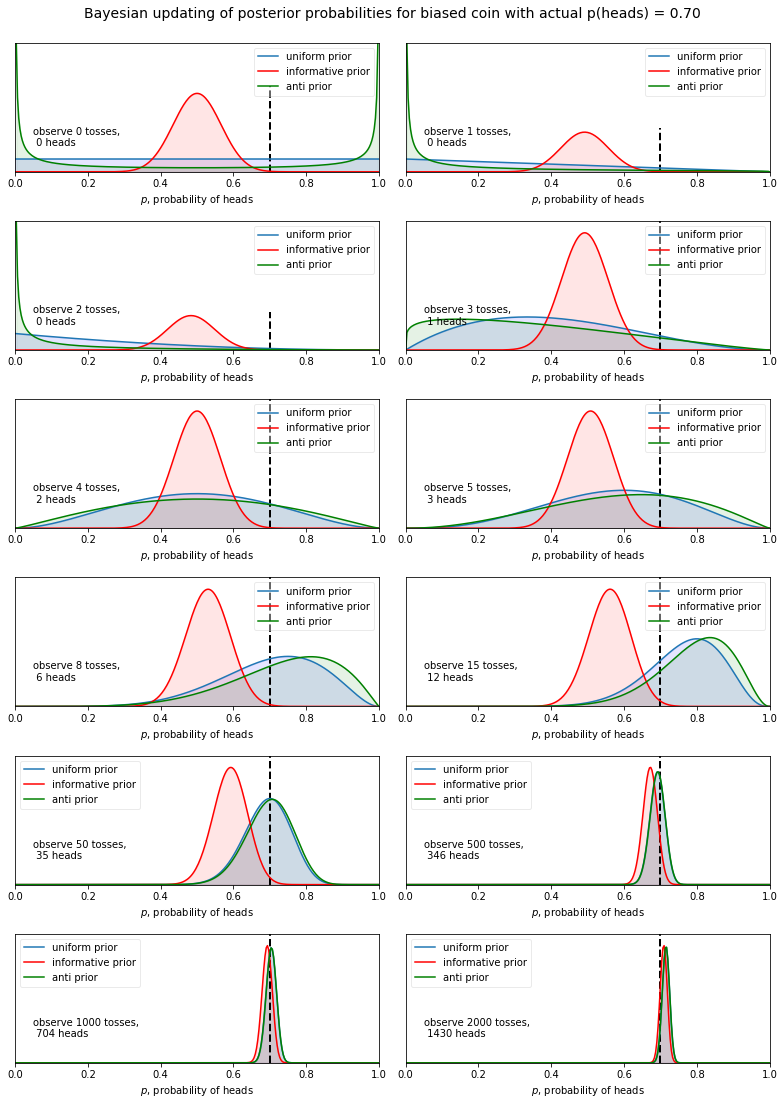

In [15]:
%matplotlib inline
# adapted from  https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 15)

import scipy.stats as stats

# If the coin is fair, prob_heads = 0.5 but you can set it to what you want.
prob_heads = 0.7

# hyperparameters for several different priors
# prior 1 is uniform in [0,1]
alpha_1 = 1
beta_1 = 1
# prior 2 is concentrated near 0.5 with very small tails
alpha_2 = 30
beta_2 = 30
# prior 3 is peaked at ends, but allows for probability everywhere
alpha_3 = .2
beta_3 = .2

# Calculate Bayesian updating using the conjugate prior for binomial, which is a beta distribution
dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000]
data = stats.bernoulli.rvs(prob_heads, size=n_trials[-1])  # heads or tails, 1 or 0
x = np.linspace(0, 1, 301) # mesh for posterior plots

for k, N in enumerate(n_trials):  # enumerate creates a tuple with a counter for each n_trials entry
    heads = data[:N].sum()   # add up the number of 1s = number of heads
    # update using the conjugate prior
    y_1 = dist.pdf(x, alpha_1 + heads, beta_1 + N - heads)   # beta(x,alpha+heads,beta+(N-heads))
    y_2 = dist.pdf(x, alpha_2 + heads, beta_2 + N - heads)   
    y_3 = dist.pdf(x, alpha_3 + heads, beta_3 + N - heads)   
    y_max = np.max([y_1.max(), y_2.max()])

    # now make the plots!
    sx = plt.subplot(len(n_trials)/2, 2, k+1)
    plt.xlabel("$p$, probability of heads") 
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.yticks([])
    plt.plot(x, y_1, label="uniform prior")
    plt.fill_between(x, 0, y_1, color="blue", alpha=0.1)
    plt.plot(x, y_2, label="informative prior", color="r")
    plt.fill_between(x, 0, y_2, color="red", alpha=0.1)
    plt.plot(x, y_3, label="anti prior", color="g")
    plt.fill_between(x, 0, y_3, color="green", alpha=0.1)
    plt.vlines(prob_heads, 0, 1.1*y_max, color="k", linestyles="--", lw=2)
    plt.annotate("observe {:d} tosses,\n {:d} heads".format(N, heads), xy=(0.05,0.35), 
                 xycoords='axes fraction', horizontalalignment='left',verticalalignment='top')
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)

figure_title = "Bayesian updating of posterior probabilities for biased coin with actual p(heads) = %1.2f" % prob_heads
plt.suptitle(figure_title,
             y=1.02,
             fontsize=14)

plt.tight_layout()

## <a name="Sampling">Sampling</a>

### <a name="Multivariate">Sampling from multivariate normal distributions</a>

Suppose we have a univariate normal distribution 
$$
  x \sim \mathcal{N}(\mu,\sigma^2)
  \ \Longleftrightarrow\
  p(x\mid\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}
     e^{-(x-\mu)^2/2\sigma^2}
$$  
If we have a way to generate <em>standard normals</em> $\mathcal{N}(0,1)$, then we can sample $x$ from
$$
    x \sim \mu + \sigma \mathcal{N}(0,1)  \;.
$$
So there is a simple shift by $\mu$ and then we scale the normal draw by $\sigma$, the square root of the variance.  

$\newcommand{\xvec}{\textbf{x}}$
$\newcommand{\muvec}{\boldsymbol{\mu}}$
The general <em>multivariate Gaussian distribution</em> is
$$
   \xvec \sim \mathcal{N}(\muvec,\Sigma)
  \ \Longleftrightarrow\
 p(\xvec\mid \muvec,\Sigma) = \frac{1}{\sqrt{\det(2\pi\Sigma)}} e^{-\frac12(\xvec-\muvec)^{\rm T}\Sigma^{-1}(\xvec-\muvec)}
$$
The generalization to sample it will be to shift by $\muvec$ and scale by some square root of the covariance matrix $\Sigma$:
$$
    \xvec \sim \muvec + B \mathcal{N}(0,I) \;,
$$
where $I$ is the identity matrix and $B B^\intercal = \Sigma$ (e.g., a Cholesky decomposition).

<p>[Return to <a href="#Contents">Contents</a>]</p>

<hr>

### <a name="MCMC">MCMC sampling</a>

Great examples of MCMC sampling are at http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/.  
<!-- Let's take a look at a 
<a href="http://www.physics.ohio-state.edu/~ntg/MCMC_javascript_visualizations.html">simplified version</a>
-->



Here are the individual simplified simulations:
<ul>
    <li>Metropolis-Hastings <a href="http://elevanth.org/mcmcdemo2/applet.html#RandomWalkMH,standard">2D Gaussian</a>
     and <a href="http://elevanth.org/mcmcdemo2/applet.html#RandomWalkMH,donut">donut</a>
    </li>
    <li>Hamiltonian Monte Carlo <a href="http://elevanth.org/mcmcdemo2/applet.html#HamiltonianMC,standard">2D Gaussian</a>
     and <a href="http://elevanth.org/mcmcdemo2/applet.html#HamiltonianMC,donut">donut</a>
    </li>
    <li>Hamiltonian Monte Carlo <a href="http://elevanth.org/mcmcdemo2/applet.html#HamiltonianMC,standard">2D Gaussian with
      U-turn</a>     
    </li>
    <li>NUTS sampler <a href="http://elevanth.org/mcmcdemo2/applet.html#NaiveNUTS,standard">2D Gaussian</a>
     and <a href="http://elevanth.org/mcmcdemo2/applet.html#NaiveNUTS,multimodal">multi-modal</a>
    </li>
</ul>

The detailed simulator can be found at https://chi-feng.github.io/mcmc-demo/, which also links to the github repository with the javascript source.

In [16]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [17]:
# At present this adversely affects the menu bar
from IPython.display import display,HTML

display(HTML(filename="./MCMC_javascript_visualizations.html"))


<p>[Return to <a href="#Contents">Contents</a>]</p>

<hr>

## <a name="Evidence">Model selection and evidence</a> 

  $\newcommand{\thetavec}{\boldsymbol{\theta}}$
  Determine the evidence for different models $M_1$ and $M_2$ via <em>marginalization</em> by integrating over all possible sets of parameters ${\thetavec}$ in different models, with the same data $D$ and information $I$. 

<img style="float:right" src="figures/Zoubin_Ghahramani_model_selection.png" width=200>
The evidence ratio for two different models:
$$ 
   \frac{p(M_1\mid D, I)}{p(M_2\mid D, I)}
   = \frac{p(D\mid M_1, I)\,p(M_1,I)}{p(D\mid M_2, I)\,p(M_2,I)}
$$

The Bayes Ratio (implements Occam’s Razor):
$$
\frac{p(D\mid M_1, I)}{p(D\mid M_2, I)}
  = \frac{\int\!d\thetavec_1\, p(D\mid\thetavec_1,M_1,I)
             \,p(\thetavec_1\mid M_1,I)}
         {\int\!d\thetavec_2\, p(D\mid\thetavec_2,M_2,I)
             \,p(\thetavec_2\mid M_2,I)}    
$$

Example: what order polynomial underlies the noisy data?
<img src="figures/Bayes_model_selection_Minka2.png" width=500>

<p>[Return to <a href="#Contents">Contents</a>]</p>

<hr>

## <a name="GPs">Gaussian processes (GPs)</a> 

### Overview of GPs

GP: the natural generalization of multivariate Gaussian random variables to infinite (countably or continuous) index sets.  They look like random functions, but with characteristic degrees of smoothness, correlation lengths, and range.  Here are some examples with different "kernels" and different parameters that dictate those features (figure from J. Melendez):

<img src="figures/gp_kernel_realizations.png" width="400" >


#### Explanations of GPs from the web

The following is adapted from a blog entry from Kathleen Bailey at http://katbailey.github.io/post/gaussian-processes-for-dummies/.

"Here’s how Kevin Murphy explains it in the excellent textbook <i>Machine Learning: A Probabilistic Perspective</i>:" 
'A GP defines a prior over functions, which can be converted into a posterior over functions once we have seen some data. Although it might seem difficult to represent a distribution over a function, it turns out that we only need to be able to define a distribution over the function’s values at a finite, but arbitrary, set of points, say $x_1, \ldots, x_N$.  A GP assumes that $p(f(x_1),\ldots,f(x_N))$ is jointly Gaussian, with some mean $\mu(x)$ and covariance $\Sigma(x)$ given by $\kappa_{ij} = \Sigma(x_i,x_j)$, where $\kappa$ is a positive definite kernel function. The key idea is that if $x_i$ and $x_j$ are deemed by the kernel to be similar, then we expect the output of the function at those points to be similar, too.'

So it is important to stress that we are really only dealing with a discrete set of points. Thus the physicist-friendly idea of a continuum limit of masses on springs may be preferred to more abstract notions in function space.

It should also be sufficient to consider the bivariate case, because the generalization from one to two variables is really where the new feature of correlation comes in.  Generalizing further really doesn't introduce anything new.

### Bivariate normal case

$\newcommand{\xvec}{\textbf{x}}$
$\newcommand{\muvec}{\boldsymbol{\mu}}$
The general multivariate Gaussian distribution is
$$
 p(\xvec\mid \muvec,\Sigma) = \frac{1}{\sqrt{\det(2\pi\Sigma)}} e^{-\frac12(\xvec-\muvec)^{\rm T}\Sigma^{-1}(\xvec-\muvec)}
$$

For the <em>bivariate</em> case we can parameterize the mean vector and covariance matrix as
$$
  \muvec = \left( \begin{array}{c}
                     \mu_x \\ \mu_y
                  \end{array}       \right)
    \;, \qquad
  \Sigma = \left( \begin{array}{cc}
                    \sigma_x^2 & \rho\sigma_x\sigma_y \\
                    \rho\sigma_x\sigma_y & \sigma_y^2
                  \end{array}
           \right)  
$$
The covariance matrix must be positive definite, which implies $\color{red}{0\lt\rho^2\lt 1}$.

If take $\mu_x = \mu_y = 0$ and $\sigma_x = \sigma_y = \sigma$ for clarity,
so that
$$
  \Sigma = \sigma^2 \left(\begin{array}{cc}
                       1 & \rho \\
                       \rho & 1
                       \end{array}
                    \right)
$$
and
$$
  p(x,y\mid \sigma,\rho) = \frac{1}{2\pi\sigma^2} 
        \exp\left(-\frac{x^2 + y^2 - 2\rho x y }{2\sigma^2\sqrt{1-\rho^2}}    
          \right)
          \;.
$$
It's clear that contours of equal probability have $x^2 + y^2 - 2\rho xy = \mbox{constant}$, so they are ellipses.  The value of $\rho$ determines the eccentricity of the ellipse.
If $\rho=0$, $x$ and $y$ are independent (uncorrelated) and we have a circle.  As $\rho$ approaches $+1$, $x$ and $y$ are increasingly correlated (toward straight line at $45^\circ$), while for $\rho$ approaching $-1$ they become increasingly anti-correlated (toward straight line at $-45^\circ$).

For reference, the Cholesky decomposition of $\Sigma$ is
$$
  \Sigma = \sigma^2\left( \begin{array}{cc}
                    1 & \rho \\
                    \rho & 1
                  \end{array}
           \right)
           =
           \sigma^2\left( \begin{array}{cc}
                    1 & 0 \\
                    \rho &  \sqrt{1-\rho^2}
                  \end{array}
           \right)  
           \left( \begin{array}{cc}
                    1 & \rho \\
                    0 &  \sqrt{1-\rho^2}
                  \end{array}
           \right)  
$$


### Example code for generating and plotting GPs

The following code is adapted from a blog post by Katherine Bailey entitled <a href="http://katbailey.github.io/post/gaussian-processes-for-dummies/"><i>Gaussian Processes for Dummies</i></a>.  First we generate several instances of draws from a Gaussian process with a squared exponential kernel function, which is the covariance between $x$ and $x'$:
$$  \kappa_{\rm SE}(x,x') = \sigma^2 e^{-(x-x')^2/2l^2} $$

<img src="figures/GP_draws_annotated.png" width="400">

So we can see that $\sigma$ controls the vertical extent of the functions while $l$ controls
how rapidly they wiggle.  Comparing to our expression above for the bivariate normal case,
we see that $\rho$ is given by $e^{-(x-x')^2/2l^2}$.  So when $x$ and $x'$ are close, 
$\rho \approx 1$ and the value of the function is highly correlated.  When $x$ and $x'$ are far apart, $\rho \rightarrow 0$, and they become independent (thus $l$ plays the role of a correlation length).

Let's generate some GPs with this kernel! For the function $f(x)$ we write draws as
$$
  f(x) \sim \mathcal{GP[\mu(x),\kappa(x,x')]}
$$
where $\mu(x)$ is the mean at each $x$ and $\kappa(x,x')$ is the covariance between $x$ and $x'$.  In practice we have a finite set of $N$ points $\textbf{x} = \{x_i\}_{i=1}^{N}$ with corresponding function values $\textbf{f}=\{f(x_i)\}_{i=1}^{N}$.
We form the mean vector $\boldsymbol{\mu} = m(\textbf{x})$ and the covariance matrix $K_{ij} = \kappa(x_i,x_j)$. Then
$$  \textbf{f} \mid \textbf{x} \sim \mathcal{N}(\boldsymbol{\mu},K)
$$
are draws from a multivariate normal distribution.  Try it:

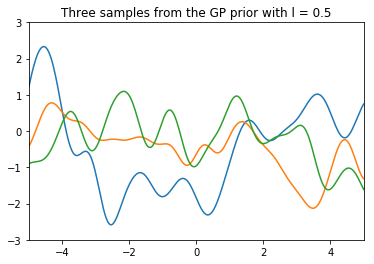

In [18]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Define the squared exponential kernel function for the covariance
#   We take the variance to be 1.
def sqr_exp_kernel(a, b, length_param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-sqdist / (2*length_param**2))

# Grid of x points
npts = 500
x_min = -5
x_max = +5
Xtest = np.linspace(x_min, x_max, npts).reshape(-1,1)   

length_param = .5  # this is "l" (correlation length)
K_ss = sqr_exp_kernel(Xtest, Xtest, length_param)

# Get Cholesky decomposition (square root) of the covariance matrix
nugget = 1e-12   # size of nugget will depend on how many points are used 
                 #  1e-12 for 500; 1e-13 for 100; 1e-15 for 50
L = np.linalg.cholesky(K_ss + nugget*np.eye(npts))

# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
# Note: mean mu = 0 here implicitly.
f_prior = np.dot(L, np.random.normal(size=(npts,3)))

# Now let's plot the 3 sampled functions.
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP prior with l = {:1.1f}'.format(length_param))
plt.show()

Now we train it on some data (see references for details):

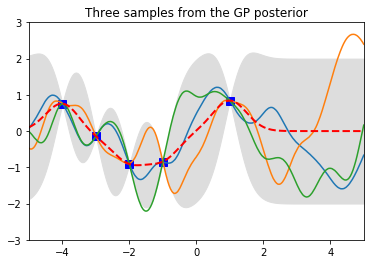

In [19]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)
#ytrain = np.array([0,0,0,0,0]).reshape(5,1)

# Apply the same kernel function to our training points
nugget_train = 5e-5
K = sqr_exp_kernel(Xtrain, Xtrain, length_param)
L = np.linalg.cholesky(K + nugget_train*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = sqr_exp_kernel(Xtrain, Xtest, length_param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((npts,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

# Draw samples from the posterior at our test points.
nugget_test = 1e-6
L = np.linalg.cholesky(K_ss + nugget_test*np.eye(npts) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(npts,3)))

plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

### Other demos for Gaussian Processes (and other regression)

<ul>
  <li>
Gaussian process regression, where you can add data points, play with the hyperparameters, and then see the inference for the curve. It’s by Tomi Peltola:
http://www.tmpl.fi/gp/  

  <li>
This simulation shows how a GP prior is a distribution over functions, and how observing data conditions the prior to obtain the GP posterior.
http://rpradeep.webhop.net/gpr/

</ul>

<p>[Return to <a href="#Contents">Contents</a>]</p>

<hr>

## <a name="Appendices">Appendices</a>

### <a name="References">References</a>

Please suggest additional references (with links).



### Physics-oriented pedagogical articles and texts

<ul>
    <li>R. Trotta,
        <a href="https://www.tandfonline.com/doi/abs/10.1080/00107510802066753"><i>Bayes in the sky: Bayesian inference and model selection in cosmology</i></a>, Contemp. Phys. <b>49</b>, 71 (2008)
        [<a href="https://arxiv.org/abs/0803.4089">arXiv:0803.4089</a>].
        
    <li>D.S. Sivia and J. Skilling,
       <a href="https://www.amazon.com/Data-Analysis-Bayesian-Devinderjit-Sivia/dp/0198568320/ref=mt_paperback?_encoding=UTF8&me=&qid="><i>Data Analysis: A Bayesian Tutorial, 2nd edition</i></a>, (Oxford University Press, 2006).
    
    <li>P. Gregory,
     <a href="https://www.amazon.com/Bayesian-Logical-Analysis-Physical-Sciences/dp/0521150124/ref=sr_1_1?s=books&ie=UTF8&qid=1538587731&sr=1-1&keywords=gregory+bayesian"><i>Bayesian Logical Data Analysis for the Physical Sciences: A Comparative Approach with Mathematica® Support</i></a>, (Cambridge University Press, 2010).
</ul>    

### Standard statistics references

<ul>
    <li>A. Gelman et al.,
        <a href="https://www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/1439840954/ref=sr_1_1?ie=UTF8&qid=1538589213&sr=8-1&keywords=gelman+bayesian+data+analysis"><i>Bayesian Data Analysis, 3rd edition</i>, (Chapman and Hall/CRC, 2013).
</ul>

### BUQEYE references

<ul>
  <li>R.J. Furnstahl, D.R. Phillips and S. Wesolowski,
      <i>A recipe for EFT uncertainty quantification in nuclear physics</i>,
      J. Phys. G <b>42</b>, 034028 (2015), [<a href="https://arxiv.org/abs/1407.0657">arXiv:1407.0657</a>].
      
  <li> R.J. Furnstahl, N. Klco, D.R. Phillips and S.Wesolowski,
    <i>Quantifying truncation errors in effective field theory</i>,
    Phys. Rev. C <b>92</b>, 024005 (2015)
    [<a href="https://arxiv.org/abs/1506.01343">arXiv:1506.01343</a>].

  <li>S. Wesolowski, N. Klco, R.J. Furnstahl, D.R. Phillips and A. Thapaliya,
  <i>Bayesian parameter estimation for effective field theories</i>,
    J. Phys. G <b>43</b>, 074001 (2016)
    [<a href="https://arxiv.org/abs/1511.03618">arXiv:1511.03618</a>].
    
  <li>  J.A. Melendez, S. Wesolowski and R.J. Furnstahl,
    <i>Bayesian truncation errors in chiral effective field theory: nucleon-nucleon observables</i>,
  Phys. Rev. C <b>96</b>, 024003 (2017)
  [<a href="https://arxiv.org/abs/1704.03308">arXiv:1704.03308</a>].
    
  <li>  S. Wesolowski, R.J. Furnstahl, J.A. Melendez and D.R. Phillips,
  <i>Exploring Bayesian parameter estimation for chiral effective field theory using nucleon-nucleon phase shifts</i>,
  [<a href="https://arxiv.org/abs/1808.08211">arXiv:1808.08211</a>].

    
</ul>    



### Github repositories

Please suggest more!

<ul>
  <li>https://github.com/jakevdp/BayesianAstronomy Materials for the Bayesian Methods in Astronomy workshop at the 227th American Astronomical Society meeting.  Includes Jupyter notebooks and useful exercises.  
      
  <li>http://people.duke.edu/~ccc14/sta-663-2018/ STA 663: Computational Statistics and Statistical Computing (2018) at Duke University.  Lots of good things here!    
</ul>

### <a name="Vocabulary">Vocabulary</a>

Plan: build up a good set of definitions with appropriate links.  Please add more words/phrases!

<dl>
<dt>conjugate prior </dt>
    <dd>If the probability distribution family (e.g., beta distributions) for the posterior pdf is the same as for the prior pdf, the latter is said to be a <a href="https://en.wikipedia.org/wiki/Conjugate_prior">conjugate prior</a>. This means that the updating by Bayes' rule can be carried out analytically.   Some Bayesian practitioners are strongly opposed to the use of conjugate priors (see <a href="https://github.com/jakevdp/BayesianAstronomy/blob/master/Index.ipynb"> comments here</a>). </dd>

<!--
<dt>contingent </dt>
    <dd> </dd>
-->

<dt>credible vs. confidence interval </dt>
    <dd>This is a contrast between Bayesian and frequentist statistics.  For a frequentist, a parameter has a true value, which is fixed and not a distribution.  A 95% confidence interval mean that with a large number of repeated trials, 95% of the calculated confidence intervals would include the true value. This is clearly hard to think about!  A Bayesian 95% credible interval is the range of the posterior for the parameter (which is treated as a random variable) that has 95% of the probability.  So there is a 95% probability that the parameter is in that interval. 
</dd>

<dt>evidence </dt>
    <dd>In the standard context of inferring parameters $\boldsymbol{\theta}$ given data $D$ and information $I$, the evidence is $p(D\mid I) = \int\! d\boldsymbol{\theta}\, p(D \mid \boldsymbol{\theta},I)\,p(\boldsymbol{\theta},I)$.  This is also called the Fully Marginalized Likelihood or FML. The expression shows that it is the integral over <i>all</i> $\boldsymbol{\theta}$ weighted by the likelihood.  This is typically an expensive integral to do.  In the context of model fitting (i.e., parameter estimation), it acts as a normalization constant and in most cases can be ignored because the normalization can be found directly (or only relative probabilities are needed). </dd>

<dt>gaussian process </dt>
    <dd>
From [Wikipedia](https://en.wikipedia.org/wiki/Gaussian_process): "In probability theory and statistics, a Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. every finite linear combination of them is normally distributed. The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space."
</dd>

<dt>hierarchical model </dt>
    <dd>A model with hyperparameters. See [Wikipedia](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling). </dd>

<dt>hyperparameter </dt>
    <dd>A parameter of a prior distribution. </dd>

<dt>iid (independently and identically distributed) </dt>
    <dd>A set of random variables is iid (or i.i.d. or IID) if each random variable has the same probability distribution and all are mutually independent. 
    </dd>

<dt>likelihood </dt>
    <dd>Usually in the form $p(D\mid \boldsymbol{\theta},I)$, where $\boldsymbol{\theta}$ are the parameters of our model, $D$ is the data, and $I$ is any other information we use.  This is the probability of observing our actual data given the model (with the particular parameters $\boldsymbol{\theta}$). It is the same quantity that is maximized in frequentist maximum-likelihood approaches. </dd>

<dt>MAP estimate</dt>
    <dd><a href="https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation">Maximum a posteriori estimate</a>. This is the mode (maximum) of the posterior distribution for the quantity of interest. If the prior is uniform, the MAP estimate equals the maximum likelihood estimate. </dd>

<dt>maximum entropy </dt>
    <dd>A method used to determine priors. </dd>

<dt>MCMC </dt>
    <dd>Markov-chain Monte Carlo. A generic name for stochastic sampling methods.  </dd>

<dt>model selection and model averaging </dt>
    <dd> </dd>

<dt>nugget </dt>
    <dd>
For Gaussian process (GP) calculations or any sampling of a multivariate normal distribution, one typically needs to find the Cholesky decomposition of the covariance matrix.  However, this matrix can become ill-conditioned (too-small or negative eigenvalues).   A standard solution is to add a small number, called a nugget, to the diagonal of the covariance matrix. For GP regression, this is equivalent to adding (or increasing, if already present) the data noise.
</dd>

<dt>nuisance parameter </dt>
    <dd>A nuisance parameter is a parameter in your model whose value you don't care about for the posterior. So you integrate it out (marginalize). </dd>
    
<dt>overfitting and underfitting</dt>
    <dd>This example from http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html of fitting polynomials to nonlinear functions illustrates overfitting and underfitting.  The true function is a cosine with noise added.  A polynomial of degree 1 is an inadequate model for this data; this is underfitting.  The polynomial of degree 15 tries to fit the noise; this is overfitting.  

  <img src="figures/sphx_glr_plot_underfitting_overfitting_001.png" width=500>
   </dd>

<dt>point estimate (cf. interval estimate) </dt>
    <dd>A point estimate is a single value to characterize a
posterior.  It could be the mode, mean, median or something
else.  An interval estimate is more natural in Bayesian statistics, because the full posterior is the real target.  Giving a series of credible intervals often conveys much of the information about the posterior.</dd>

<dt>posterior </dt>
    <dd>This is the quantity of the left side of Bayes' rule, the thing we want to compute.  Often in the form $p(\boldsymbol{\theta}\mid D,I)$, where $\boldsymbol{\theta}$ are the parameters of our model, $D$ is the data, and $I$ is any other information we use. It is our knowledge of the model given the data and any relevant background knowledge (which include the choice of model). </dd>

<dt>prior </dt>
    <dd>A pdf that encodes what is known about the answer (e.g., parameters) before any data is used. The notation consistent with our definitions of <i>posterior</i> and <i>likelihood</i> is $p(\boldsymbol{\theta}\mid I)$, where $\boldsymbol{\theta}$ are the parameters of our model and $I$ is any other information we use (e.g., some of the parameters must be positive or less than a known magnitude because of physics reasons).
     See also <i>conjugate prior</i> and <i>maximum entropy</i>.
    </dd>

<dt>residual</dt>
    <dd>The difference of theory prediction and experimental data.
    </dd>

<dt> </dt>
    <dd> </dd>

   
</dl>

### <a name="Notation">Notation</a>  &nbsp;&nbsp;<span class="red">[still coming . . .]</span>



Plan: build up a dictionary of notation with appropriate links and examples (with code).

univariate normal distribution
$$\mathcal{N}(\mu,\sigma^2)$$



<hr>

<p>[Return to <a href="#Contents">Contents</a>]</p>

<hr>